In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
class Fundamentals():
    """ Fundamentals objects to be instantiated as a class variable within class Traders.
    
    Arguments:
        - volatility: how volatile are the fundamentals from period to period.
        - initial_value: starting value of fundamental value.
        
    Methods:
        - self.next_day():
            Changes security price.
            Turns day (internal state variable) into the next one.
    
    """
    def __init__(self, volatility=0.01, initial_value=1):
        self.volatility = volatility
        self.value = initial_value
        
        self.time = 0
        self.values = [self.value, ]
        
    def next_day(self):
        value_change = np.random.randn() * self.volatility
        self.value += value_change
        self.values.append(self.value)
        self.time += 1

    def __str__(self):
        return f"Fundamentals for time {self.time}: value: {self.value}"

        
class Market():
    """ The Market object. This is the basic object to be manipulated in this notebook.
    
    Arguments:
        - number: of participants.
        - prop_fundamentalists: proportion of traders initially trading on fundamentals
        
    Methods:
        - self.determine_demand(self):
            Works out demand using the calculate_demand method for each trader.
            Returns the sum
            
        - self.run_trial(self):
            Works out market price for the day based on formula from [Day & Huang (1990)]
            Carries out purchases and sales for investors
            Turns day into the next.
            
        - self.get_neighbour_traders(self):
            Gets traders from local area. Starts by selecting random neighbours, as Fundamentalists and Chartists start segregated
            Probably would have been smarter to just randomly assign fundamentalists and chartists.
            
        - self.make_traders(self):
            Makes traders, given the number and proportion required.
            # TODO: Random Assignment to method "F" and "C" instead of segregating.
    """
    
    def __init__(self, number=1000, prop_fundamentalists=0.5):
        self.number = number
        self.proportion = prop_fundamentalists
        self.adjustment = .00020
        self.make_traders(self.proportion, self.number)
        self.price = 1
        self.time = 0
        self.prices = [self.price, ]
        self.fundamentals = Fundamentals() #Todo: change type of traders?
        
        self.shock_volatility = 0.025
        
    def determine_demand(self):
        """ Misleading name. Not only returns demand, but also is the mechanism for exchanging shares for cash."""
        demands = 0
        scores = dict({})
        
        ## Populate lists with buyers and sellers
        buys = []
        sells = []
        for investor in self.traders:
            demand, score, investor = investor.calculate_demand(self)
            if demand > 0:
                buys.append(investor)
            elif demand < 0:
                sells.append(investor)
            demands += demand
            scores[investor] = score
        
        
        ## Get lists of buyers most highly rating assets, and sellers rating it the least.
        buys.sort(key=lambda x: int(x.calculate_demand(self)[1]), reverse=True)
        sells.sort(key=lambda x: x.calculate_demand(self)[1])
        
        ## Match buyers and sellers
        if demand > 0: # There are more buyers than sellers
            buys[:-demand]
        elif demand < 0:
            sells[:demand]
        
        ## Settle trades
        for buyer in buys:
            buyer.wealth -= self.price
            buyer.stock += 1
        for seller in sells:
            seller.wealth += self.price
            seller.stock -= 1

        return demands
        
    def run_trial(self, verbose=False):
        noise = np.random.randn() * self.shock_volatility
        net_excess_demand = self.determine_demand()
        
        self.price += self.adjustment * (1 + net_excess_demand) + noise
        self.prices.append(self.price)
        
        ## Work out success
        for trader in self.traders:
            trader.evaluate_beliefs(self)
        
        ## Change date
        self.time += 1
        self.fundamentals.next_day()
        
        if verbose:
            print(self.time, ": Market Time")
            print(self.fundamentals.time, ": Fundamentals Time")
            print(self.fundamentals.value)
            print(self.price)
            
    def get_neighbour_traders(self, number_of_observations, index):
        """Neighbours are randomly selected. After a sufficient amount of time has passed, they are selected by proximity"""
        if self.time < 7: # Hyperparameter
            neighbours_indicies = np.random.choice(self.number, number_of_observations, replace=False)
            traders = [self.traders[i] for i in neighbours_indicies]
            return traders
        else:
            if index + number_of_observations < len(self.traders):
                traders = self.traders[index: index + number_of_observations]
                return traders
            else:
                traders = self.traders[index - number_of_observations: index]
                return traders
        
    def make_traders(self, proportion, number):
        """
        args:
            - proportion (float): proportion of traders fundamentalist in decimal
            - number (int): Total number of traders in universe
        returns:
            - traders (tuple): 
                * tuple[0] (list): fundamentalist traders
                * tuple[1] (list): chartist traders
        """

        traders = []
        for i in range(number):
            rand = np.random.random()
            if rand < proportion:
                traders.append(Trader("F"))
            else:
                traders.append(Trader("C"))
        self.traders = traders
        
    def __str__(self):
        return f"Market Statistics: \nDay: {self.time}\nTraders: {self.number}\nPrice: {self.price}"
        
        
class Trader():
    """ The trader object. 
    
    Arguments:
        - method: The method of trading, based on fundamentals or charts
    
    """
    fundamental_belief_mean = 0.05
    fundamental_belief_std = 0.01
    
    chartist_belief_mean = 0.04
    chartist_belief_std = 0.01
    
    fundamental_error_std = 0.01
    chartist_error_std = 0.05
    
    intensity_choice = 2
    
    def __init__(self, method):
        self.wealth = 500
        self.stock = 500
        self.method = method # either "F" - fundamental, or "C" - chartist
        self.make_beliefs()
        
    def make_beliefs(self):
        """Call this method everytime Trader object changes method"""
        self.memory = np.random.random()
        self.belief = np.random.randn()
        if self.method == "F": self.belief = self.belief * Trader.fundamental_belief_std + Trader.fundamental_belief_mean
        else: self.belief = self.belief * Trader.chartist_belief_std + Trader.chartist_belief_mean
        self.score = 0
            
    def evaluate_beliefs(self, market):
        if market.time < 1: 
            self.score = 0
            return None
        self_index = market.traders.index(self)
        neighbours = market.get_neighbour_traders(10, self_index)
        
        fundamentalists = [i for i in neighbours if i.method == "F"]
        chartists = [j for j in neighbours if j.method == "C"]
        
        if fundamentalists == [] or chartists == []:
            return None
        
        def calc_score(self, market, neighbour):
            exp_diff =  (np.exp(market.price) - np.exp(market.prices[-2]))
            memory_term = self.memory * self.score
            
            if neighbour.method == "F":
                fund_diff = self.belief * (market.fundamentals.value - market.price)
                score = exp_diff + fund_diff + memory_term
            else:
                chart_diff = self.belief * (market.price - market.prices[-2])
                score = exp_diff + chart_diff + memory_term
            self.score = score
            return score
        
        average_score_funds = sum([calc_score(self, market, i) for i in fundamentalists])/len(fundamentalists)
        average_score_chart = sum([calc_score(self, market, j) for j in chartists])/len(chartists)
        
        
        score = np.exp(Trader.intensity_choice * average_score_funds)/(np.exp(Trader.intensity_choice * average_score_funds) \
                                                                       + np.exp(Trader.intensity_choice * average_score_chart))
        
        if self.method == "F" and score < 0.40:
            self.method = "C"
            self.make_beliefs()
        elif self.method == "C" and score > 0.60:
            self.method = "F"
            self.make_beliefs()
        return None
    
    def calculate_demand(self, market):
        """This method means Trader needs Market() to function."""
        if self.method == "F":
            diff = market.fundamentals.value - market.price
            demand = self.belief * (diff) + (np.random.randn() * Trader.fundamental_error_std)
            
        else:
            ## if data available
            if len(market.prices) > 1:
                diff = market.price - market.prices[-2]
            else:
                diff = 0
            demand = self.belief * (diff) + (np.random.randn() * Trader.chartist_error_std)
            

        if demand > 0 and self.wealth > market.price:
            return (1, demand, self)
        elif demand < 0 and self.stock > 0:
            return (-1, demand, self)
        else: return (0, 0, self)
            
    
    def __repr__(self):
        return f"{self.method} Trader. Wealth = {self.wealth}. Beliefs = {self.belief}"




In [187]:
#set up experiment
sns.set_style("darkgrid")

volatilities_market = []
volatilities_fundamentals = []

market = Market(number=1000, prop_fundamentalists=0.9)

1.5230376720428467
16
16


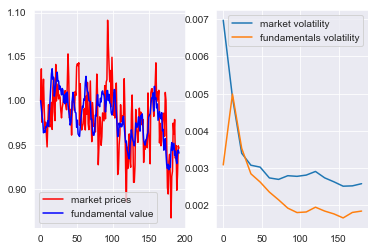

In [206]:
## Run the experiment
fig, (ax1, ax2) = plt.subplots(1, 2)


timer_start = time.time()
for i in range(12):
    market.run_trial()
sns.lineplot(x=range(market.time+1), y=market.prices, color="r", label="market prices", ax=ax1);
sns.lineplot(x=range(market.time+1), y=market.fundamentals.values, color="b", label="fundamental value", ax=ax1);
timer_end = time.time()
print(timer_end - timer_start)

# calculate volatilities
prices_market = np.array(market.prices)
values_market = np.array(market.fundamentals.values)

market_vol = np.std(prices_market)/np.sqrt(market.time)
fund_vol = np.std(values_market)/np.sqrt(market.time)
volatilities_market.append(market_vol)
volatilities_fundamentals.append(fund_vol)

# plot volatilities
print(len([12 * i for i in range(int(market.time/12))]))
print(len(volatilities_market))

sns.lineplot(x=[12 * i for i in range(int(market.time/12))], y=volatilities_market, label="market volatility", ax=ax2)
sns.lineplot(x=[12 * i for i in range(int(market.time/12))], y=volatilities_fundamentals, label="fundamentals volatility", ax=ax2)

In [184]:
# calculate volatilities
prices_market = np.array(market.prices)
values_market = np.array(market.fundamentals.values)

market_vol = np.std(prices_market)/np.sqrt(market.time)
fund_vol = np.std(values_market)/np.sqrt(market.time)
volatilities_market.append(market_vol)
volatilities_fundamentals.append(fund_vol)

0.00824558525131881  variation in market prices
0.007679285087209847  variation in fundamental values


16
16


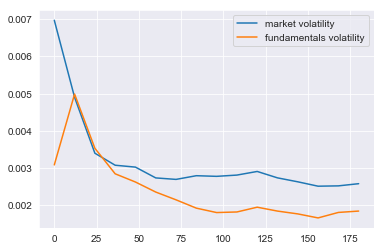

In [207]:
# plot volatilities
print(len([12 * i for i in range(int(market.time/12))]))
print(len(volatilities_market))

sns.lineplot(x=[12 * i for i in range(int(market.time/12))], y=volatilities_market, label="market volatility")
sns.lineplot(x=[12 * i for i in range(int(market.time/12))], y=volatilities_fundamentals, label="fundamentals volatility")

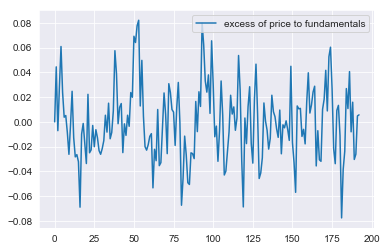

In [208]:
sns.lineplot(x=range(market.time+1), y=np.array(market.prices)-np.array(market.fundamentals.values), label="excess of price to fundamentals")

In [101]:
print("Number of Fundamentalists: ", len([(i.wealth, i.stock, i.method) for i in market.traders if i.method == "F"]))
print("Number of Chartists: ", len([i for i in market.traders if i.method == "C"]))

print("Wealth of Fundamentalists:", sum([i.wealth + i.stock * market.price for i in market.traders if i.method == "F"]))
print("Wealth of Chartists:", sum([i.wealth + i.stock * market.price for i in market.traders if i.method == "C"]))

Number of Fundamentalists:  723
Number of Chartists:  277
Wealth of Fundamentalists: 670355.2390881263
Wealth of Chartists: 256635.30003751116


In [67]:
[12 * i for i in range(int(market.time/12))]

[0, 12]